# Class Mapping 

|Label | prob | type|
|------|------|-----|
|0     | 0.0  | mono|
|1     | 0.333| mono|
|2     | 0.667| mono|
|3     | 1.0  | mono|
|4     | 0.0  | poly|
|5     | 0.333| poly|
|6     | 0.667| poly|
|7     | 1.0  | poly|

In [1]:
from utils.classifier import *
from utils.dataloader import *
from utils.features import *
from utils.helper import *
from utils.processing import *
import pickle

In [2]:
RANDOM_STATE = 66
ROOT_PATH, DATA_PATH, OUT_PATH = get_paths()
PARAMS = []
print(ROOT_PATH)

/Users/moooooo16/Documents/Computer Vision/Project/elpv


In [3]:
from sklearn.model_selection import train_test_split
img_path, prob, types, labels= load_data(DATA_PATH)

feature_builder = FeatureExtraction(DATA_PATH, img_path, labels)
X_train, X_test, y_train, y_test = feature_builder.split_data(train_test_split, randome_state=RANDOM_STATE, stratify=True, split_ratio=0.25)

[0 1 2 3 4 5 6 7] [588 117  56 313 920 178  50 402]


In [4]:
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# autoAug 
# Genearte more 
augment_funcs = [
    # flip_x,
    # flip_y,
    # rotate,
    # salt_pepper_noise,
]

preprocess_pipeline = [
    # (strech_img, {
    #     }),
    # (clach_img, {
    #     'clipLimit': 2.0,
    #     'tileGridSize': (8, 8)}),
    # (guassian_blur, {
    #     'kernel_size': (0, 0),
    #     'sigmaX': 3}),
    # (lap_feature, {
    #     'dst': -1,
    #     'ksize' : 5}),
    # (morpo_opening, {
    #     'kernel': np.ones((2,2), np.uint8),
    #     'iterations': 1}),
    # (morph_smoothing, {
    # 'ses' : feature_builder.ses})
]

# Smaller cell: more features
# 
hog_params = {
    'orient': 10,
    'pix_per_cell': 10,
    'cell_per_block': 1,
    'vis': False,
    'block_norm': 'L2'
}

svm_param = {
    'C': 10,
    'kernel' : 'rbf',
    # 'gamma' : 0.0001,
    # 'class_weight' : 'balanced',
    # 'verbose' : False,
}

grid_svm_params = {
    'estimator': SVC,
    'model_params': {
        'kernel': ['rbf', 'linear'],
        'C' : [0.1, 0.3, 0.5, 0.7, 1, 3, 5, 7 ,9, 10],
        'class_weight': ['balanced']},
    'scoring': {
        "F1_Weighted": make_scorer(f1_score, average='weighted'),
        "Balanced_Accuracy": make_scorer(balanced_accuracy_score),},
    'refit': 'F1_Weighted',
    'verbose' : 0
}

smote_params = {
    'total_classes': np.unique(y_train),
    'grid_param': grid_svm_params,
    'knn' : KNeighborsClassifier,
    'n_neighbors': 5,
}

PARAMS.append(augment_funcs)
PARAMS.append(preprocess_pipeline)
PARAMS.append(hog_params)
# PARAMS.append(svm_param)
# PARAMS.append(grid_svm_params)
PARAMS.append(smote_params)

In [5]:
X_train_aug, y_train_aug = feature_builder.augmentation(X_train, y_train, augment_funcs=augment_funcs)

In [6]:
X_train_prepro = feature_builder.preprocess(X_train_aug, preprocess_pipeline = preprocess_pipeline)
X_test_prepro = feature_builder.preprocess(X_test, preprocess_pipeline = preprocess_pipeline)

print(X_train_prepro.shape, y_train_aug.shape)
print(X_test_prepro.shape, y_test.shape)

(1968, 300, 300) (1968,)
(656, 300, 300) (656,)


In [7]:
train_hog_des = feature_builder.get_hog_features(X_train_prepro, **hog_params)
test_hog_des = feature_builder.get_hog_features(X_test_prepro, **hog_params)

print(train_hog_des.shape)
print(test_hog_des.shape)

Calculating descriptors: 100%|██████████| 656/656 [00:04<00:00, 133.31it/s]


(1968, 9000)
(656, 9000)


In [8]:
with open (os.path.join(OUT_PATH, 'hog_des.pkl'), 'wb') as f:
    pickle.dump((train_hog_des, test_hog_des), f)

In [9]:
train_hog_des, test_hog_des = None, None

with open(os.path.join(OUT_PATH, 'hog_des.pkl'), 'rb') as f:
    train_hog_des, test_hog_des = pickle.load(f)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_hog_des)
train_X = scaler.transform(train_hog_des)
test_X = scaler.transform(test_hog_des)  

In [11]:
mono_train_X, poly_train_X, mono_train_y, poly_train_y = mono_poly_split(train_X, y_train_aug)
mono_test_X, poly_test_X, mono_test_y, poly_test_y = mono_poly_split(test_X, y_test)
combine_train_X, combine_train_y = combine_mono_poly(mono_train_X, poly_train_X, mono_train_y, poly_train_y)
combine_test_X, combine_test_y = combine_mono_poly(mono_test_X, poly_test_X, mono_test_y, poly_test_y)

In [12]:
data_sets = {
    'mono_svm': (mono_train_X, mono_train_y, mono_test_X, mono_test_y),
    'poly_svm': (poly_train_X, poly_train_y, poly_test_X, poly_test_y),
    'combined_svm': (combine_train_X, combine_train_y, combine_test_X, combine_test_y)
}

----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       147
           1       0.58      0.24      0.34        29
           2       0.00      0.00      0.00        14
           3       0.89      0.71      0.79        78

    accuracy                           0.75       268
   macro avg       0.55      0.47      0.49       268
weighted avg       0.72      0.75      0.72       268



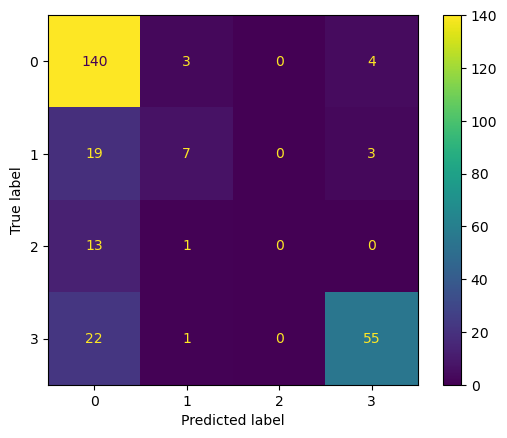


----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.71      0.87      0.79       230
           1       0.62      0.11      0.19        45
           2       0.00      0.00      0.00        13
           3       0.61      0.60      0.61       100

    accuracy                           0.69       388
   macro avg       0.49      0.40      0.39       388
weighted avg       0.65      0.69      0.64       388



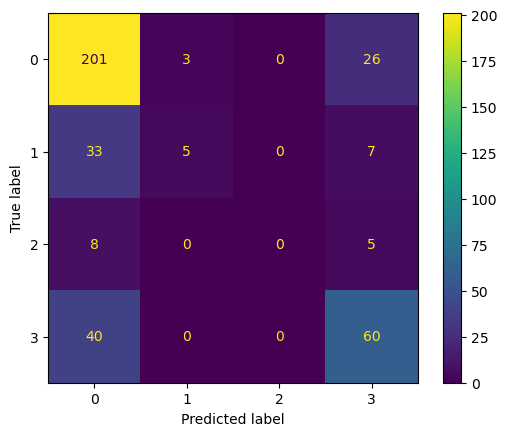


----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       377
           1       0.57      0.16      0.25        74
           2       0.00      0.00      0.00        27
           3       0.66      0.67      0.66       178

    accuracy                           0.70       656
   macro avg       0.49      0.43      0.43       656
weighted avg       0.66      0.70      0.66       656



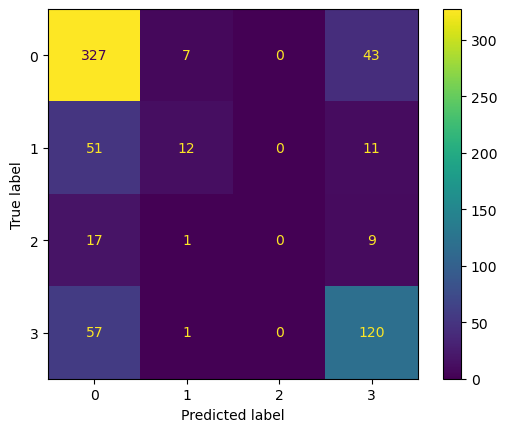

In [13]:
svm_metrics = []

for name in data_sets.keys():
    train_X, train_y, test_X, test_y = data_sets[name]
    svm = SVC(**svm_param).fit(train_X, train_y)
    predictions = svm.predict(test_X)
    acc, f1 = get_report(test_y, predictions, name)
    svm_metrics.append((name, acc, f1))

with open(os.path.join(OUT_PATH, 'hog_svm_metrics.pkl'), 'wb') as f:
    pickle.dump(svm_metrics, f)

Class: [0 1 2 3] Val Score: 0.71 use {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       147
           1       0.44      0.24      0.31        29
           2       0.00      0.00      0.00        14
           3       0.87      0.69      0.77        78

    accuracy                           0.74       268
   macro avg       0.51      0.47      0.47       268
weighted avg       0.70      0.74      0.70       268



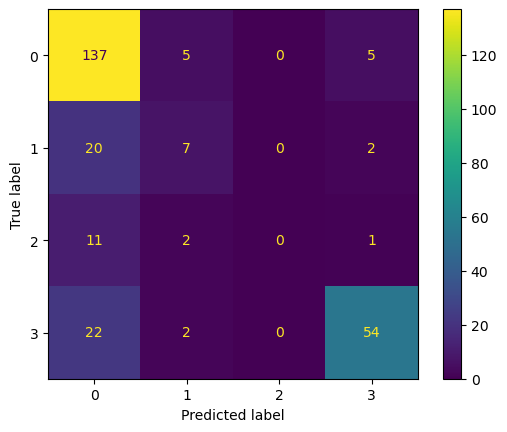


Class: [0 1 2 3] Val Score: 0.67 use {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       230
           1       0.48      0.22      0.30        45
           2       0.00      0.00      0.00        13
           3       0.62      0.55      0.59       100

    accuracy                           0.67       388
   macro avg       0.45      0.41      0.41       388
weighted avg       0.63      0.67      0.64       388



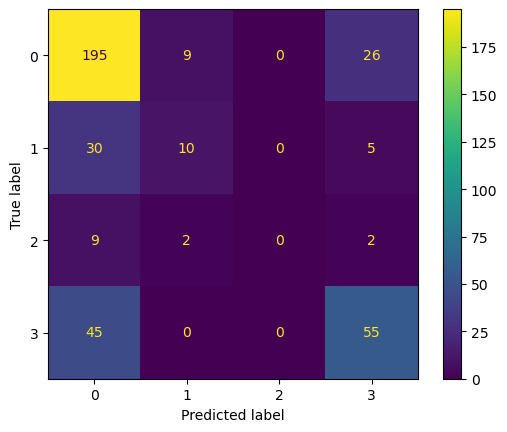


Class: [0 1 2 3] Val Score: 0.65 use {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       377
           1       0.43      0.20      0.28        74
           2       1.00      0.07      0.14        27
           3       0.67      0.65      0.66       178

    accuracy                           0.69       656
   macro avg       0.70      0.44      0.46       656
weighted avg       0.68      0.69      0.66       656



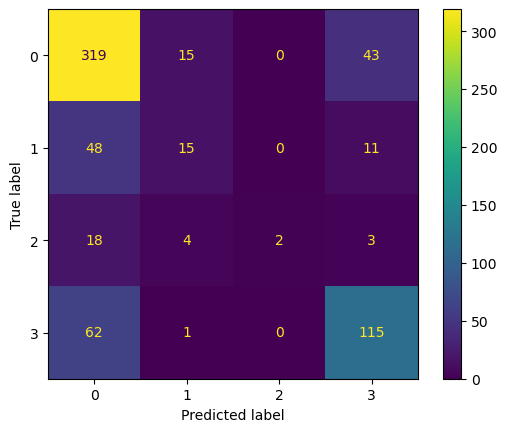

In [14]:
grid_metrics = []

for name in data_sets.keys():
    train_X, train_y, test_X, test_y = data_sets[name]
    result, best_clf  = grid_search(train_X, train_y, **grid_svm_params)
    grid_pred = best_clf.predict(test_X)
    acc, f1 = get_report(test_y, grid_pred, name)
    grid_metrics.append((name, acc, f1))

with open(os.path.join(OUT_PATH, 'hog_grid_metrics.pkl'), 'wb') as f:
    pickle.dump(grid_metrics, f)